In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 4.3 MB/s 


In [3]:
import os
import glob
from tqdm import tqdm_notebook as tqdm
import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
path = '/content/drive/MyDrive/data'
pytorch3dpath = '/content/drive/MyDrive/data/EfficientNet-PyTorch-3D'

sys.path.append(pytorch3dpath)

In [23]:
train_df = pd.read_csv(f'{path}/train_labels.csv')
#train_data = pd.read_csv(os.path.join(path, 'train_labels.csv'))
print('Num of train samples:', len(train_df))
train_df.head()

Num of train samples: 585


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [25]:
def dicom2array(path, voi_lut=True, fix_monochrome=True, remove_black_boundary=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    if remove_black_boundary:
        (x, y) = np.where(data > 0)
        if len(x) > 0 and len(y) > 0:
            x_mn = np.min(x)
            x_mx = np.max(x)
            y_mn = np.min(y)
            y_mx = np.max(y)
            if (x_mx - x_mn) > 10 and (y_mx - y_mn) > 10:
                data = data[:,np.min(y):np.max(y)]
    data = cv2.resize(data, (256, 256))
    return data

def load_3d_dicom_images(scan_id, split = "train", channel_expand = True, remove_black_boundary=True):
    """
    we will use some heuristics to choose the slices to avoid any numpy zero matrix (if possible)
    """
    flair = sorted(glob.glob(f"{path}/{split}/{scan_id}/FLAIR/*.dcm"))
    t1w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1w/*.dcm"))
    t1wce = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1wCE/*.dcm"))
    t2w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T2w/*.dcm"))
    
    
    flair_img = np.array([dicom2array(a, remove_black_boundary = remove_black_boundary) for a in flair[len(flair)//2 - 32:len(flair)//2 + 32]]).T
    
    if len(flair_img) == 0:
        flair_img = np.zeros((256, 256, 64))
    elif flair_img.shape[-1] < 64:
        n_zero = 64 - flair_img.shape[-1]
        flair_img = np.concatenate((flair_img, np.zeros((256, 256, n_zero))), axis = -1)
    #print(flair_img.shape)
        
    
    
    t1w_img = np.array([dicom2array(a, remove_black_boundary = remove_black_boundary) for a in t1w[len(t1w)//2 - 32:len(t1w)//2 + 32]]).T
    
    if len(t1w_img) == 0:
        t1w_img = np.zeros((256, 256, 64))
    elif t1w_img.shape[-1] < 64:
        n_zero = 64 - t1w_img.shape[-1]
        t1w_img = np.concatenate((t1w_img, np.zeros((256, 256, n_zero))), axis = -1)
    #print(t1w_img.shape)
    
    
    t1wce_img = np.array([dicom2array(a, remove_black_boundary = remove_black_boundary) for a in t1wce[len(t1wce)//2 - 32:len(t1wce)//2 + 32]]).T
    
    if len(t1wce_img) == 0:
        t1wce_img = np.zeros((256, 256, 64))
    elif t1wce_img.shape[-1] < 64:
        n_zero = 64 - t1wce_img.shape[-1]
        t1wce_img = np.concatenate((t1wce_img, np.zeros((256, 256, n_zero))), axis = -1)
    #print(t1wce_img.shape)
    
    
    t2w_img = np.array([dicom2array(a, remove_black_boundary = remove_black_boundary) for a in t2w[len(t2w)//2 - 32:len(t2w)//2 + 32]]).T
    
    if len(t2w_img) == 0:
        t2w_img = np.zeros((256, 256, 64))
    elif t2w_img.shape[-1] < 64:
        n_zero = 64 - t2w_img.shape[-1]
        t2w_img = np.concatenate((t2w_img, np.zeros((256, 256, n_zero))), axis = -1)
    #print(t2w_img.shape)
    
    return np.concatenate((flair_img, t1w_img, t1wce_img, t2w_img), axis = -1) if not channel_expand else np.moveaxis(np.array((flair_img, t1w_img, t1wce_img, t2w_img)), 0, -1)

In [7]:
load_3d_dicom_images("00000", channel_expand = False).shape

(256, 256, 256)

In [8]:
slices = load_3d_dicom_images("00000", remove_black_boundary=False)
print(slices.shape)

(256, 256, 64, 4)


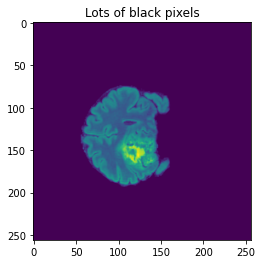

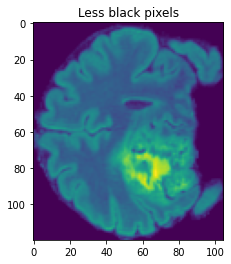

In [17]:
# doing a little more cleaning up
s_slice = slices[:,:,0,0]
plt.imshow(s_slice)
plt.title("Lots of black pixels")
plt.show()
(x, y) = np.where(s_slice > 0)
ns_slice = s_slice[np.min(x):np.max(x),np.min(y):np.max(y)]
plt.title("Less black pixels")
plt.imshow(ns_slice)
plt.show()

In [9]:
views = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
def load_imgs(idx):
    slices = load_3d_dicom_images(idx)
    imgs = {}
    for i, view in enumerate(views):
        imgs[view] = slices[:,:,:,i].swapaxes(0, -1)
    return imgs

for i in range(10,32):
    idx = str(i).zfill(5)
    imgs = load_imgs(idx)

In [35]:
class BrainTumor(Dataset):
    def __init__(self, path = path, split = "train", validation_split = 0.2):
        # labels
        train_data = pd.read_csv(os.path.join(path, 'train_labels.csv'))
        self.labels = {}
        brats = list(train_data["BraTS21ID"])
        mgmt = list(train_data["MGMT_value"])
        for b, m in zip(brats, mgmt):
            self.labels[str(b).zfill(5)] = m
            
        if split == "valid":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob(path + f"/train/" + "/*"))]
            self.ids = self.ids[:int(len(self.ids)* validation_split)] # first 20% as validation
        elif split == "train":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob(path + f"/{split}/" + "/*"))]
            self.ids = self.ids[int(len(self.ids)* validation_split):] # last 80% as train
        else:
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob(path + f"/{split}/" + "/*"))]
            
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        imgs = load_3d_dicom_images(self.ids[idx], self.split)
        imgs = imgs - imgs.min()
        imgs = (imgs + 1e-5) / (imgs.max() - imgs.min() + 1e-5)
        
        # imgs = imgs - imgs.mean()
        # imgs = (imgs + 1e-5)/(imgs.std() + 1e-5)
        
        if self.split != "test":
            label = self.labels[self.ids[idx]]
            return torch.tensor(imgs, dtype = torch.float32).permute(-1, 0, 1, 2), torch.tensor(label, dtype = torch.long)
        else:
            return torch.tensor(imgs, dtype = torch.float32).permute(-1, 0, 1, 2)

In [36]:
# testing the dataloader
train_dataset = BrainTumor()
train_bs = 4
train_loader = DataLoader(train_dataset, batch_size = train_bs, shuffle=True)

val_dataset = BrainTumor(split = "valid")
val_bs = 2
val_loader = DataLoader(val_dataset, batch_size = val_bs, shuffle=True)

In [37]:
for img, label in train_loader:
    print(img.shape)
    print(img.max())
    print(img.mean())
    print(img.min())
    print(label.shape)
    break

for img, label in val_loader:
    print(img.shape)
    print(label.shape)
    break

torch.Size([4, 4, 256, 256, 64])
tensor(1.)
tensor(1.)
tensor(1.)
torch.Size([4])
torch.Size([2, 4, 256, 256, 64])
torch.Size([2])


In [38]:
PATH = ('/content/drive/MyDrive/data/EfficientNet-PyTorch-3D/EfficientNet-PyTorch-master/efficientnet-b0-08094119.pth')
from efficientnet_pytorch_3d import EfficientNet3D

In [39]:
model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=4)
#model.load_state_dict(torch.load(PATH))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.25)
n_epochs = 10

In [ ]:
from monai.networks.nets.densenet import DenseNet121
def build_model():
  model = DenseNet121(spatial_dims=1, in_channels=1, out_channels=1)
  return model

In [32]:
print(model)
model(torch.randn(1, 4, 256, 256, 64))

EfficientNet3D(
  (_conv_stem): Conv3dStaticSamePadding(
    4, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock3D(
      (_depthwise_conv): Conv3dStaticSamePadding(
        32, 32, kernel_size=(3, 3, 3), stride=[2, 2, 2], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
      )
      (_bn1): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv3dStaticSamePadding(
        32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv3dStaticSamePadding(
        8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv3dStaticS

tensor([[-0.0358,  0.1962]], grad_fn=<AddmmBackward0>)

In [24]:
print(model)
model(torch.randn(1, 4, 256, 256, 64))

EfficientNet3D(
  (_conv_stem): Conv3dStaticSamePadding(
    4, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock3D(
      (_depthwise_conv): Conv3dStaticSamePadding(
        32, 32, kernel_size=(3, 3, 3), stride=[2, 2, 2], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
      )
      (_bn1): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv3dStaticSamePadding(
        32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv3dStaticSamePadding(
        8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv3dStaticS

tensor([[-0.0528,  0.1688]], grad_fn=<AddmmBackward0>)

In [21]:
def one_hot(arr):
    return [[1, 0] if a_i == 0 else [0, 1] for a_i in arr]

In [40]:
gpu = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
model.to(gpu)

train_loss = []
val_loss = []
train_roc = []
val_roc = []
best_roc = 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times
    y_all = []
    outputs_all = []
    running_loss = 0.0
    roc = 0.0
    
    model.train()
    for i, data in tqdm(enumerate(train_loader, 0)):
        x, y = data
        
        # x = torch.unsqueeze(x, dim = 1)
        x = x.to(gpu)
        y = y.to(gpu)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        y_all.extend(y.tolist())
        outputs_all.extend(outputs.tolist())
    
    roc += roc_auc_score(one_hot(y_all), outputs_all) / train_bs
    print(f"epoch {epoch+1} train loss: {running_loss} train roc: {roc}")
    
    train_loss.append(running_loss)
    train_roc.append(roc)

    y_all = []
    outputs_all = []
    running_loss = 0.0
    roc = 0.0 
    
    model.eval()
    for i, data in tqdm(enumerate(val_loader, 0)):

        x, y = data
        
        # x = torch.unsqueeze(x, dim = 1)
        x = x.to(gpu)
        y = y.to(gpu)

        # forward
        outputs = model(x)
        loss = criterion(outputs, y)

        # print statistics
        running_loss += loss.item()
        y_all.extend(y.tolist())
        outputs_all.extend(outputs.tolist())
    
    roc += roc_auc_score(one_hot(y_all), outputs_all) / val_bs
    scheduler.step(running_loss)
        
    print(f"epoch {epoch+1} val loss: {running_loss} val roc: {roc}")
    
    val_loss.append(running_loss)
    val_roc.append(roc)
    
    if roc > best_roc:
        best_roc = roc
        torch.save(model.state_dict(), f'best_roc_{round(roc, 2)}_loss_{round(running_loss, 2)}.pt')

0it [00:00, ?it/s]

epoch 1 train loss: 85.92812895774841 train roc: 0.13411429722405332


0it [00:00, ?it/s]

epoch 1 val loss: 40.877085745334625 val roc: 0.25


0it [00:00, ?it/s]

epoch 2 train loss: 83.47840896248817 train roc: 0.12226708415732807


0it [00:00, ?it/s]

epoch 2 val loss: 41.1782329082489 val roc: 0.25


0it [00:00, ?it/s]

epoch 3 train loss: 83.173579454422 train roc: 0.11336565223760346


0it [00:00, ?it/s]

epoch 3 val loss: 41.05468261241913 val roc: 0.2459016393442623


0it [00:00, ?it/s]

epoch 4 train loss: 83.86289435625076 train roc: 0.12220757342708562


0it [00:00, ?it/s]

epoch 4 val loss: 40.82251816987991 val roc: 0.2540983606557377


0it [00:00, ?it/s]

epoch 5 train loss: 81.97630846500397 train roc: 0.12658847872262508


0it [00:00, ?it/s]

epoch 5 val loss: 40.96451264619827 val roc: 0.25


0it [00:00, ?it/s]

epoch 6 train loss: 82.14649748802185 train roc: 0.12211830733172196


0it [00:00, ?it/s]

epoch 6 val loss: 40.86635082960129 val roc: 0.24553571428571427


0it [00:00, ?it/s]

epoch 7 train loss: 81.5874696969986 train roc: 0.12094411484655387


0it [00:00, ?it/s]

epoch 7 val loss: 40.81985765695572 val roc: 0.25


0it [00:00, ?it/s]

epoch 8 train loss: 82.18415069580078 train roc: 0.12005145389291731


0it [00:00, ?it/s]

epoch 8 val loss: 40.823077857494354 val roc: 0.2520491803278688


0it [00:00, ?it/s]

epoch 9 train loss: 81.16152626276016 train roc: 0.12052525086061672


0it [00:00, ?it/s]

epoch 9 val loss: 40.83739751577377 val roc: 0.2459016393442623


0it [00:00, ?it/s]

epoch 10 train loss: 81.25631809234619 train roc: 0.12303385702775947


0it [00:00, ?it/s]

epoch 10 val loss: 40.82800757884979 val roc: 0.2520491803278688


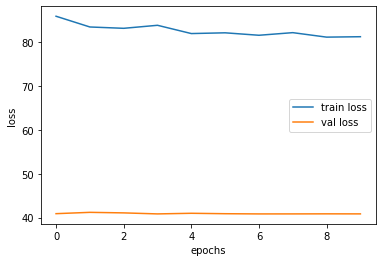

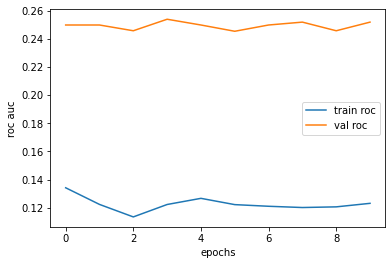

In [41]:
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

plt.plot(train_roc, label = 'train roc')
plt.plot(val_roc, label = 'val roc')
plt.xlabel('epochs')
plt.ylabel('roc auc')
plt.legend(['train roc', 'val roc'])
plt.show()